In [ ]:
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2

!tar -xvf LJSpeech-1.1.tar.bz2

Streaming output truncated to the last 5000 lines.
LJSpeech-1.1/wavs/LJ022-0089.wav
LJSpeech-1.1/wavs/LJ030-0192.wav
LJSpeech-1.1/wavs/LJ041-0078.wav
LJSpeech-1.1/wavs/LJ045-0249.wav
LJSpeech-1.1/wavs/LJ034-0035.wav
LJSpeech-1.1/wavs/LJ010-0152.wav
LJSpeech-1.1/wavs/LJ036-0174.wav
LJSpeech-1.1/wavs/LJ035-0076.wav
LJSpeech-1.1/wavs/LJ032-0176.wav
LJSpeech-1.1/wavs/LJ046-0113.wav
LJSpeech-1.1/wavs/LJ017-0096.wav
LJSpeech-1.1/wavs/LJ004-0098.wav
LJSpeech-1.1/wavs/LJ010-0147.wav
LJSpeech-1.1/wavs/LJ042-0230.wav
LJSpeech-1.1/wavs/LJ041-0033.wav
LJSpeech-1.1/wavs/LJ045-0229.wav
LJSpeech-1.1/wavs/LJ014-0199.wav
LJSpeech-1.1/wavs/LJ002-0082.wav
LJSpeech-1.1/wavs/LJ006-0055.wav
LJSpeech-1.1/wavs/LJ045-0120.wav
LJSpeech-1.1/wavs/LJ050-0028.wav
LJSpeech-1.1/wavs/LJ045-0215.wav
LJSpeech-1.1/wavs/LJ013-0121.wav
LJSpeech-1.1/wavs/LJ008-0025.wav
LJSpeech-1.1/wavs/LJ005-0240.wav
LJSpeech-1.1/wavs/LJ044-0026.wav
LJSpeech-1.1/wavs/LJ048-0127.wav
LJSpeech-1.1/wavs/LJ006-0195.wav
LJSpeech-1.1/wavs/LJ030-0

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import librosa
import os

In [ ]:
class LJSpeechPreprocessor():

  def __init__(self, data_dir, num_samples=None):
    self.data_dir = data_dir
    self.metadata = self.read_metadata(num_samples)

  def read_metadata(self, num_samples):
    """Read meta data"""
    fpath = os.path.join(self.data_dir, "metadata.csv")
    metadata = pd.read_csv(fpath, sep='|', header=None, quoting=3)
    metadata.columns = ["ID", "Transcription", "Normalized Transcription"]
    metadata = metadata[["ID", "Normalized Transcription"]] 
    metadata = metadata.sample(frac=1.0).reset_index(drop=True)

    if num_samples:
      metadata = metadata[:min(num_samples, metadata.shape[0])]

    return metadata

  def get_wavs_list(self):
    """get list of file path of .wav data"""
    wav_dir = os.path.join(self.data_dir, "wavs")
    wavs_list = [os.path.join(wav_dir, fname+".wav") for fname in self.metadata["ID"]]
    return wavs_list

  def get_original_text(self):
    """get original sentences"""
    return self.metadata["Normalized Transcription"].tolist()

  def get_target_sequence(self, SOS="", EOS=""):
    """get tokenized and indexed sentences """
    target_text= [SOS + txt + EOS for txt in self.metadata["Normalized Transcription"]]

    tokenizer = Tokenizer(char_level=True)
    tokenizer.fit_on_texts(target_text)

    target_seq = tokenizer.texts_to_sequences(target_text)
    target_seq = pad_sequences(target_seq, padding="post")

    vocab = tokenizer.word_index
    vocab["<UNK>"] = 0

    vocab_rev = dict((id, char) for char, id in vocab.items())

    return target_seq, vocab, vocab_rev

  @staticmethod
  def get_spectograms(wavs_list, n_mels, norm=True):
    """get the spectrogram corresponding to each audio"""
    spectograms = []
    for fpath in wavs_list:
      wav, sr = librosa.load(fpath, sr=None)
      spect = librosa.feature.melspectrogram(wav, sr, n_fft=1024, n_mels=n_mels)
      spect = np.transpose(spect)

      if norm:
        mean = np.mean(spect, 1).reshape((-1,1))
        std = np.std(spect, 1).reshape((-1,1))
        spect = (spect-mean) / std
      spectograms.append(spect)
    
    spectograms = pad_sequences(spectograms, padding="post")
    return spectograms


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import numpy as np
import math

In [ ]:
class Dataloader(Sequence):
  """dataloader for speech transformer model"""
  def __init__(self, wavs_list, target_sequence, n_mels, batch_size=64):
    self.wavs_list = wavs_list
    self.targets = target_sequence
    self.n_mels = n_mels
    self.batch_size = batch_size
    self.fnum = len(wavs_list)
    self.targets_shift = np.zeros(self.targets.shape)
    self.targets_shift[:, :-1] = self.targets.copy()[:, 1:]

  def __len__(self):
    return math.ceil((self.fnum / self.batch_size))

  def __getitem__(self, idx):
    st = idx * self.batch_size
    ed = min((idx+1) * self.batch_size, self.fnum)

    targets = self.targets[st: ed, :] # shape (samples, length)
    targets_shifts = self.targets_shift[st:ed, :]  # shape (samples, length)
    inputs = LJSpeechPreprocessor.get_spectograms(self.wavs_list[st:ed], self.n_mels) # shape (samples, mxlen, n_mels)
    return [inputs, targets], targets_shifts

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Input, Layer, Attention, Reshape, Add, Conv2D, TimeDistributed, MultiHeadAttention, Dense, Embedding, LayerNormalization
import keras.backend as K

In [ ]:
class MultiHeadAttention2D(Layer):
  def __init__(self, num_heads):
    """
    A simple implementation of 2D Multi-Head Attention proposed in paper
    "Speech-Transformer——A No-Recurrence Sequence-to-Sequence Model for Speech Recognition"
    Note that the MultiHeadAttention2D can only be used as self-attention,
    since it contains a transpose operation in "frequency attention"
    Argument:
    :param num_heads: number of attention heads, i.e. number of filters of convolution
    """

    super().__init__()

    self.num_heads = num_heads
    self.conv_Q = Conv2D(filters=num_heads, kernel_size=5, padding="same")
    self.conv_V = Conv2D(filters=num_heads, kernel_size=5, padding="same")
    self.conv_K = Conv2D(filters=num_heads, kernel_size=5, padding="same")
    self.conv_out = Conv2D(filters=1, kernel_size=5, padding="same")

  def call(self, query, value, key=None):
    """
    :param query: Query Tensor of shape (batch_size, Tq, dim)
    :param value: Value Tensor of shape (batch_size, Tv, dim)
    :param key: Key Tensor of shape (batch_size, Tv, dim). If not
    given, will use 'value' for both 'key' and 'value'
    """

    if not key:
      key = value

    # expand (channel) dimension to apply convolution
    # shape (batch_size, T, dim) -> (batch_size, T, dim, 1)
    query = K.expand_dims(query, axis=-1)
    value = K.expand_dims(value, axis=-1)
    key = K.expand_dims(key, axis=-1)

    # shape (batch_size, T, dim, num_heads)
    feat_Q = self.conv_Q(query)
    feat_V = self.conv_V(value)
    feat_K = self.conv_K(key)

    # Separate feature maps by channel
    # Then generate a list of tuples of length num_heads
    # like [(Q1, V1, K1), (Q2, V2, K2), ..., (Qn, Vn, Kn)]
    combined = [
        (feat_Q[:,:,:,i], feat_V[:,:,:,i],feat_K[:,:,:,i]) for i in range(self.num_heads)
        ]

    # transpose feature maps to apply frequency attention
    combined_transpose = [
        (K.permute_dimensions(feat_query, (0, 2, 1)),
         K.permute_dimensions(feat_value, (0, 2, 1)),
         K.permute_dimensions(feat_key, (0, 2, 1)))
        for feat_query, feat_value, feat_key in combined
        ]

    out_temporal_atten = [
        Attention()([feat_query, feat_value, feat_key]) 
        for feat_query, feat_value, feat_key in combined
        ]

    out_frequncy_atten = [
        Attention()([feat_query_trans, feat_value_trans, feat_key_trans]) 
        for feat_query_trans, feat_value_trans, feat_key_trans in combined_transpose
        ]

    # concatenate feature maps by channel
    feat_time = K.concatenate([K.expand_dims(feat, -1) for feat in out_temporal_atten], axis=-1)    
    feat_freq = K.concatenate([K.expand_dims(feat, -1) for feat in out_frequncy_atten], axis=-1)

    feat = K.concatenate([feat_time, K.permute_dimensions(feat_freq, (0, 2, 1, 3))], axis=-1)    
    outputs = self.conv_out(feat)
    outputs = K.squeeze(outputs, axis=-1)

    return outputs


In [ ]:
class TransformerEncoderSubLayer(Layer):
  """ 
  sublayer of speech transformer's encoder
  """
  def __init__(self, latent_dim, num_heads=16, hidden_dim=1024):
    """
    :param latent_dim: input and output dimensions of each timestep
    :param num_heads: number of attention heads, i.e. number of filters of
    each convolution network in 2D multi-head attention
    :param hidden_dim: number of units of hidden layer in feedforward network
    """
    super().__init__()

    self.multi_head_atten_2D = MultiHeadAttention2D(num_heads=num_heads)
    self.feedforward = Sequential(
        [Dense(hidden_dim, activation="relu"), 
         Dense(latent_dim)])
    
    self.layernorm1 = LayerNormalization()
    self.layernorm2 = LayerNormalization()

  def call(self, inputs):    
    x = self.multi_head_atten_2D(inputs, inputs)
    x = Add()([x, inputs])
    outputs_atten = self.layernorm1(x)

    x = self.feedforward(outputs_atten)
    x = Add()([x, outputs_atten])
    outputs = self.layernorm2(x)

    return outputs

In [ ]:
class TransformerDecoderSublayer(Layer):
  """ 
  sublayer of speech transformer's decoder
  """

  def __init__(self, latent_dim, num_heads=4, key_dim=64, hidden_dim=1024):
    """
    :param latent_dim: input and output dimensions of each timestep
    :param num_heads: number of attention heads
    :param key_dim: output dimensions of projection step in multi-head attention
    :param hidden_dim: number of units of hidden layer in feedforward network
    """

    super().__init__()
    self.multi_head_atten_mask = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
    self.multi_head_atten = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
    self.feedforward = Sequential([
        Dense(hidden_dim, activation="relu"),
        Dense(latent_dim)])
    
    self.layernorm1 = LayerNormalization()
    self.layernorm2 = LayerNormalization()
    self.layernorm3 = LayerNormalization()

  def get_feature_mask(self, inputs):
    """ 
    future mask for self-attention
    return a lower triangular matrix with shape (samples, T_Q, T_K) where T_Q = T_K
    """
    input_shape = tf.shape(inputs)
    batch_size, seq_length = input_shape[0], input_shape[1]

    i = tf.range(seq_length)[:, tf.newaxis]
    j = tf.range(seq_length)

    # generate lower triangular matrix. shape: (length, length)
    mask = tf.cast(i >= j, dtype="int32")

    # tile to shape (batch_size, length, length)
    mask = tf.reshape(mask, (1, seq_length, seq_length))
    mult = tf.concat([
        tf.expand_dims(batch_size, -1), tf.constant([1,1], dtype=tf.int32)], 
        axis=0)

    return tf.tile(mask, mult)

  def call(self, inputs, outputs_enc):
    future_mask = self.get_feature_mask(inputs)

    x = self.multi_head_atten_mask(inputs, inputs, attention_mask=future_mask)
    x = Add()([x, inputs])
    outputs_atten_mask = self.layernorm1(x)

    x = self.multi_head_atten(inputs, outputs_enc)
    x = Add()([x, outputs_atten_mask])
    outputs_atten = self.layernorm2(x)

    x = self.feedforward(outputs_atten)
    x = Add()([x, outputs_atten])
    outputs = self.layernorm3(x)

    return outputs


In [ ]:
class PositionEmbedding(Layer):
  """ 
  positional embedding layer
  """

  def __init__(self, max_len, latent_dim):
    super().__init__()
    self.embedding_pos = Embedding(max_len, latent_dim)

  def call(self, inputs):
    seq_length = tf.shape(inputs)[1]
    positions = tf.range(start=0, limit=seq_length, delta=1)
    embedded_pos = self.embedding_pos(positions)
    return embedded_pos


In [ ]:
class SpeechTransformer:
  def __init__(self, train_dataset_dir="/content/LJSpeech-1.1"):
    preprocessor = LJSpeechPreprocessor(train_dataset_dir, num_samples=None)
    self.wavs_list = preprocessor.get_wavs_list()
    self.orginal_text = preprocessor.get_original_text()
    self.target_seq, self.vocab, self.vocab_rev = preprocessor.get_target_sequence(SOS="\t", EOS="\n")
    self.vocab_size = len(self.vocab.keys())
    self.max_len_audio = 512
    self.max_len_text = self.target_seq.shape[1]
    self.latent_dim = 128
    self.model = self.build_model()

  def build_encoder(self, num_sublayer):
    inputs_audio = Input(shape=(None, self.latent_dim))

    x = K.expand_dims(inputs_audio, -1)
    x = Conv2D(filters=32, kernel_size=[7,7], strides=2, padding="same", activation="relu")(x)
    x = Conv2D(filters=32, kernel_size=[7,7], strides=2, padding="same", activation="relu")(x)

    x = Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    x = TimeDistributed(Dense(self.latent_dim, activation="relu"))(x)
    x = x + PositionEmbedding(self.max_len_audio, self.latent_dim)(x)

    for _ in range(num_sublayer):
      x = TransformerEncoderSubLayer(self.latent_dim, hidden_dim=512)(x)

    return Model(inputs_audio, x)

  def build_decoder(self, num_sublayer):
    inputs_tar = Input(shape=(None, ))
    outputs_enc = Input(shape=(None, self.latent_dim))

    embedded_token = Embedding(self.vocab_size, self.latent_dim)(inputs_tar)
    embedded_pos = PositionEmbedding(self.max_len_text, self.latent_dim)(inputs_tar)
    x = embedded_token + embedded_pos

    for _ in range(num_sublayer):
      x = TransformerDecoderSublayer(self.latent_dim, hidden_dim=512)(x, outputs_enc)

    return Model([inputs_tar, outputs_enc], x)

  def build_model(self):
    encoder = self.build_encoder(num_sublayer=3)
    decoder = self.build_decoder(num_sublayer=3)

    inputs_audio = Input(shape=(None, self.latent_dim))
    inputs_target = Input(shape=(None, ))

    outputs_enc = encoder(inputs_audio)
    outputs_dec = decoder([inputs_target, outputs_enc])

    prob = TimeDistributed(Dense(self.vocab_size, activation="softmax"))(outputs_dec)

    model = Model([inputs_audio, inputs_target], prob)

    # there's no need to pass one-hot tensor when using sparse_categorical_crossentropy
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model

  def recognize(self, spect):
    # blank target sentence, which only has a <sos> symbol
    output_seq = np.zeros((1,1))
    output_seq[0, 0] = self.vocab['\t']

    max_length = 80
    res = ""
    for _ in range(max_length):
      outputs = self.model.predict([spect, output_seq])
      output_idx = np.argmax(outputs[0, -1, :])
      output_word = self.vocab_rev[output_idx]

      # stop when <eos> symbol has been generated
      if output_word == '\n':
        break

      res += output_word

      # next input of decoder
      output_seq = np.hstack((output_seq, np.zeors(1,1)))
      output_seq[0, -1] = output_idx
    
    return res

  def test(self):
    for i in range(5):
      inputs = LJSpeechPreprocessor.get_spectograms(self.wavs_list[i:i+1], self.latent_dim)
      res = self.recognize(inputs[0:1])
      print('-')
      print("Decoded Sentence: ", res)
      print("Ground Truth: ", self.orginal_text[i])

  def train_model(self, epochs, batch_size):
    dataloader = Dataloader(self.wavs_list, self.target_seq, self.latent_dim, batch_size=batch_size)

    self.model.fit(dataloader, epochs=epochs)

    self.test()
    self.model.save_weights("./SpeechTransformer.h5")


In [ ]:
speechtransformer = SpeechTransformer(train_dataset_dir="/content/LJSpeech-1.1")

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, None, 128)]  0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 model_6 (Functional)           (None, None, 128)    651363      ['input_23[0][0]']               
                                                                                                  
 model_7 (Functional)           (None, None, 128)    1220096     ['input_24[0][0]',               
                                                                  'model_6[0][0]']          

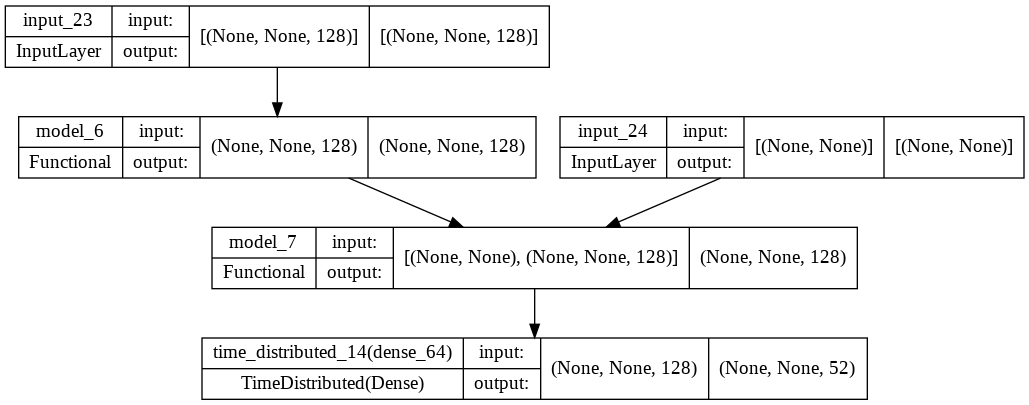

In [ ]:
speechtransformer.model.summary()

tf.keras.utils.plot_model(speechtransformer.model, show_shapes=True)

In [ ]:
speechtransformer.train_model(epochs=50, batch_size=64)

Epoch 1/50
131/205 [==================>...........] - ETA: 37:55 - loss: 1.3673 - accuracy: 0.6070